In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

DATA_PATH = "/content/drive/MyDrive/project/data/"
SEED = 42

In [3]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [6]:
from sklearn.metrics import mean_squared_error

def rmse(y_valid, pred):
    mse = mean_squared_error(y_valid, pred)
    return np.sqrt(mse)

In [7]:
from sklearn.metrics import make_scorer

rmse_score = make_scorer(rmse, greater_is_better=False)

In [8]:
# 결측치 채우기
train["AlogP"] = np.where(pd.isna(train["AlogP"]), train["LogD"], train["AlogP"])
test["AlogP"] = np.where(pd.isna(test["AlogP"]), test["LogD"], test["AlogP"])

# EDA

## 전체 데이터 시각화

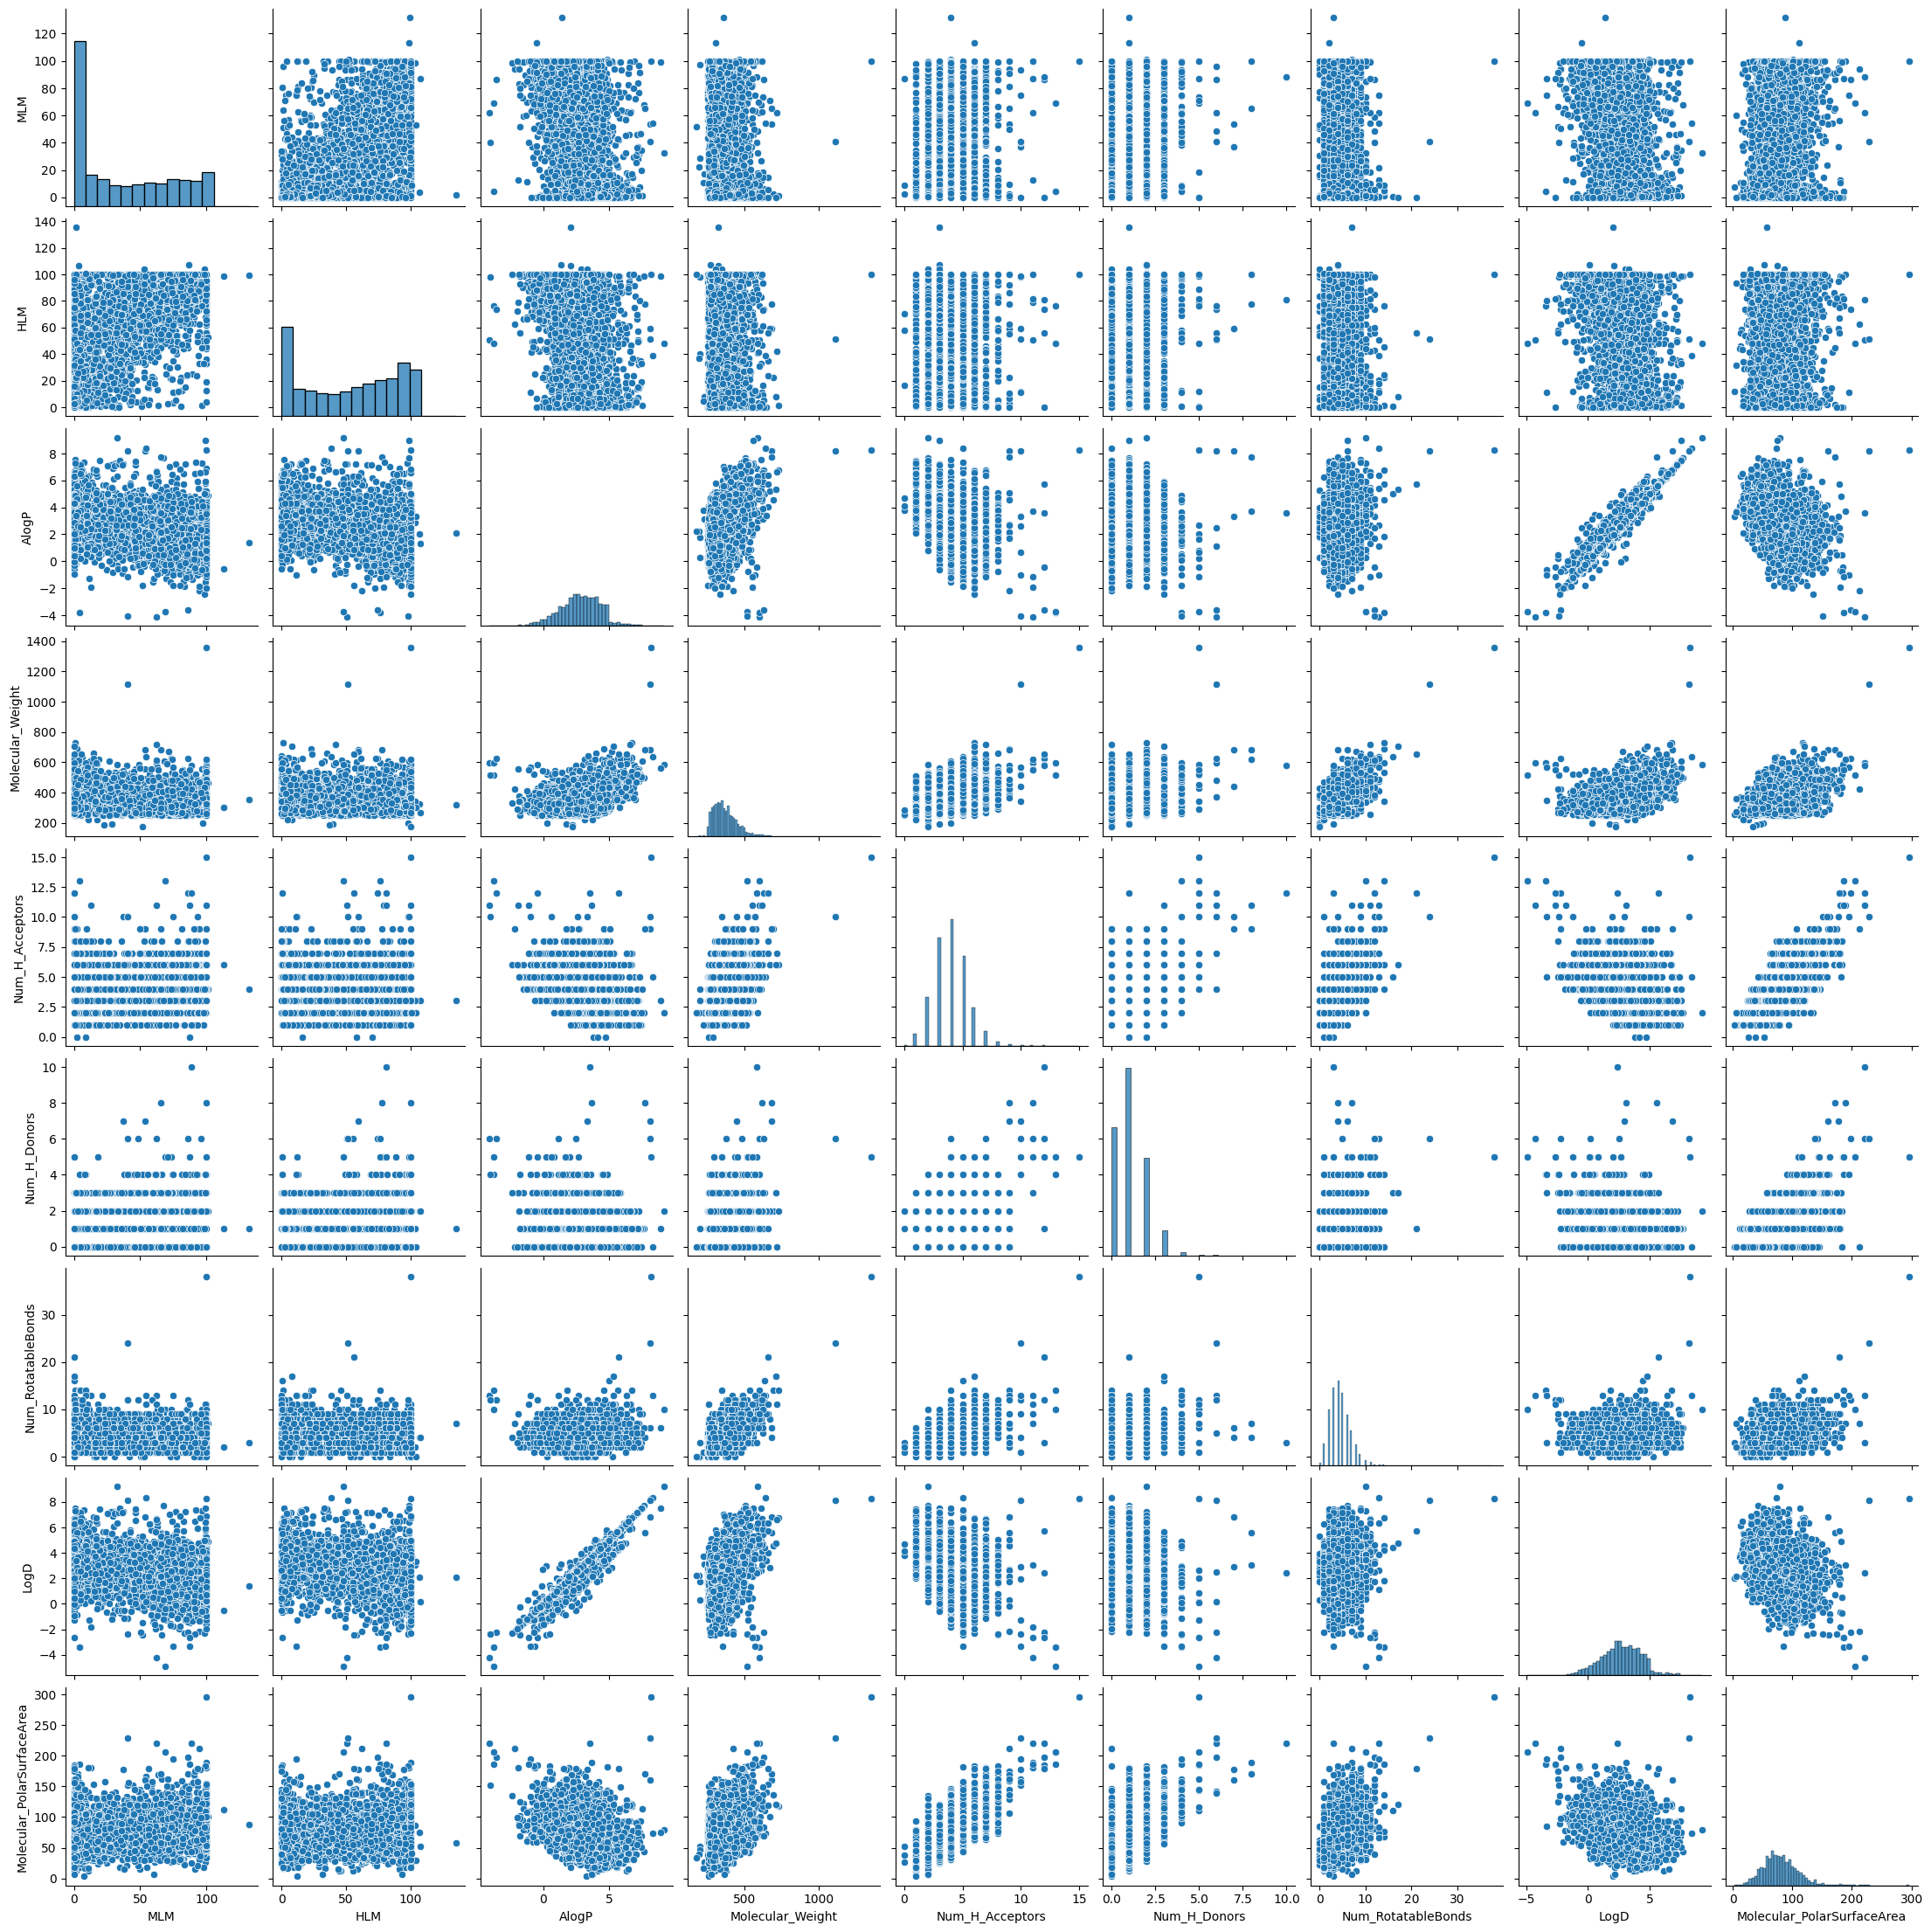

In [ ]:
sns.pairplot(train)

## 선형 형태의 데이터만 시각화

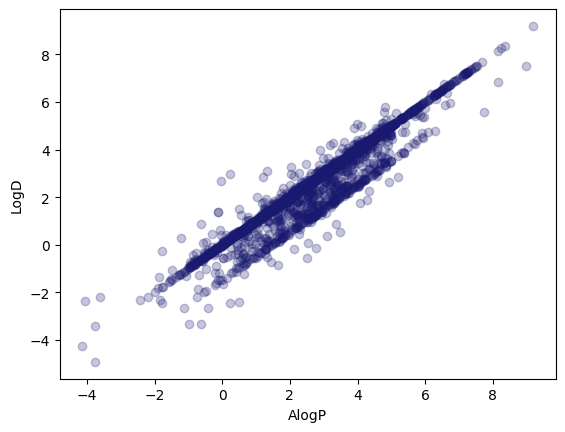

In [ ]:
plt.scatter(x='AlogP',
            y='LogD',
            data=train,
            c='midnightblue',
            alpha=.25)
plt.xlabel("AlogP")
plt.ylabel("LogD")
plt.show()

## LogP[D] 와 M[H]LM의 시각화

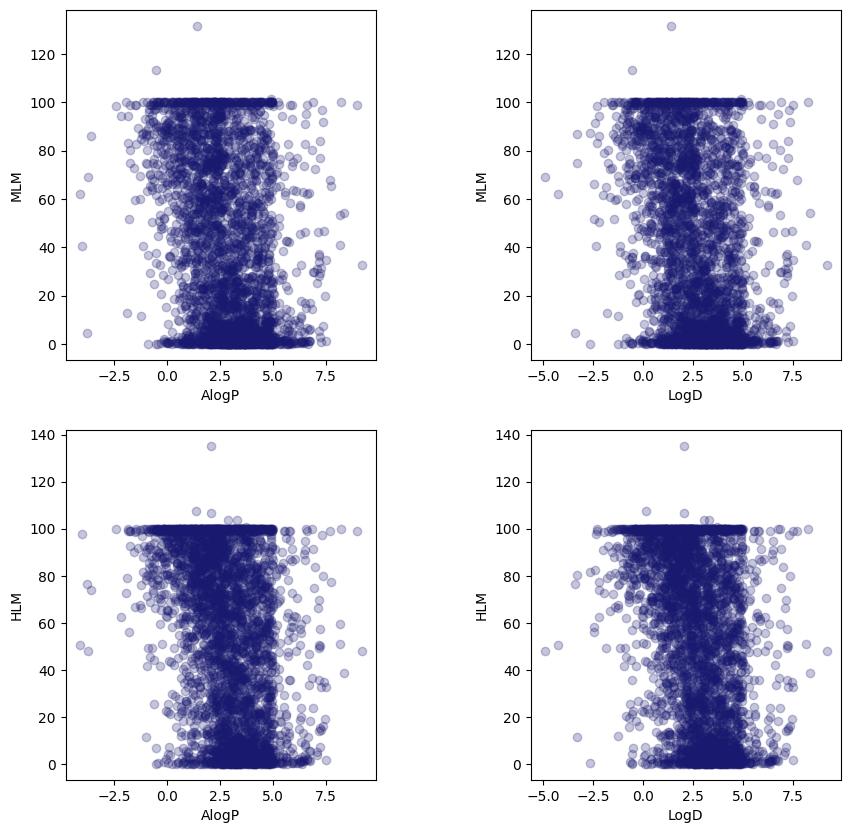

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['MLM', 'HLM']

plt.figure(figsize=(10, 10))

for i in range(len(y_list)):
    for j in range(len(x_list)):
        plt.subplot(2, 2, i * len(x_list) + j + 1)
        plt.scatter(x=x_list[j],
                    y=y_list[i],
                    data=train,
                    c='midnightblue',
                    alpha=0.25)
        plt.xlabel(x_list[j])
        plt.ylabel(y_list[i])
        plt.subplots_adjust(wspace=0.5)

plt.show()

### 이상치 확인(100%를 초과한 데이터)

In [9]:
print(len(train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0)]))
display(train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0)])

9


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
662,TRAIN_0662,O=C(Nc1ccccc1)C1CCCN1C1=NS(=O)(=O)c2ccccc21,131.720,99.570,1.412,355.411,4,1,3,1.412,87.22
1092,TRAIN_1092,COc1c(NC(=O)c2ccc[nH]2)cc(Cl)cc1C(=O)N(C)C,3.820,106.510,2.061,321.759,3,2,4,2.061,74.43
1584,TRAIN_1584,CN(C)S(=O)(=O)CCNCc1ccc(-c2ccccc2)cc1,1.745,135.336,2.075,318.434,3,1,7,2.052,57.79
2159,TRAIN_2159,N#Cc1nccnc1OC1CCN(C(=O)N2CCNC2=O)C1,113.210,99.000,-0.533,302.289,6,1,2,-0.533,111.44
2410,TRAIN_2410,CC(C)CCC1CCN(C(=O)C2CC(O)CN2)CC1,86.878,107.323,1.345,268.395,3,2,4,0.139,52.57
2586,TRAIN_2586,Cc1nc(-c2c[nH]c(C(=O)N3CCOc4cc(F)ccc43)c2)cs1,98.550,103.720,2.876,343.375,3,1,2,3.032,86.46
2948,TRAIN_2948,CCCC(=O)Nc1cc(C(=O)NC2CCCCC2)ccc1S(=O)(=O)c1cc...,101.380,52.330,4.906,462.989,4,2,7,4.906,100.72
3157,TRAIN_3157,CN1C(=O)c2cccc3c2C1=Cc1ccc2ccccc2c1O3,52.847,103.907,3.319,299.323,2,0,0,3.319,29.54
3403,TRAIN_3403,c1cnc2c(C3NCCc4c3[nH]c3ccccc43)cccc2c1,8.890,100.830,3.719,299.369,2,2,1,3.719,40.71


In [10]:
over_100 = train[(train['MLM'] > 100.0) | (train['HLM'] > 100.0)]
over_100.index

Int64Index([662, 1092, 1584, 2159, 2410, 2586, 2948, 3157, 3403], dtype='int64')

### 이상치 제거

In [11]:
train.drop(index=over_100.index, axis=0, inplace=True)
train

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.556,3.079,3.409,396.195,3,1,5,3.409,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccc...,35.560,47.630,1.912,359.381,4,1,3,1.844,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.150,1.790,1.941,261.320,3,1,6,2.124,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.030,2.770,0.989,284.696,5,1,5,0.989,91.51


- 재확인

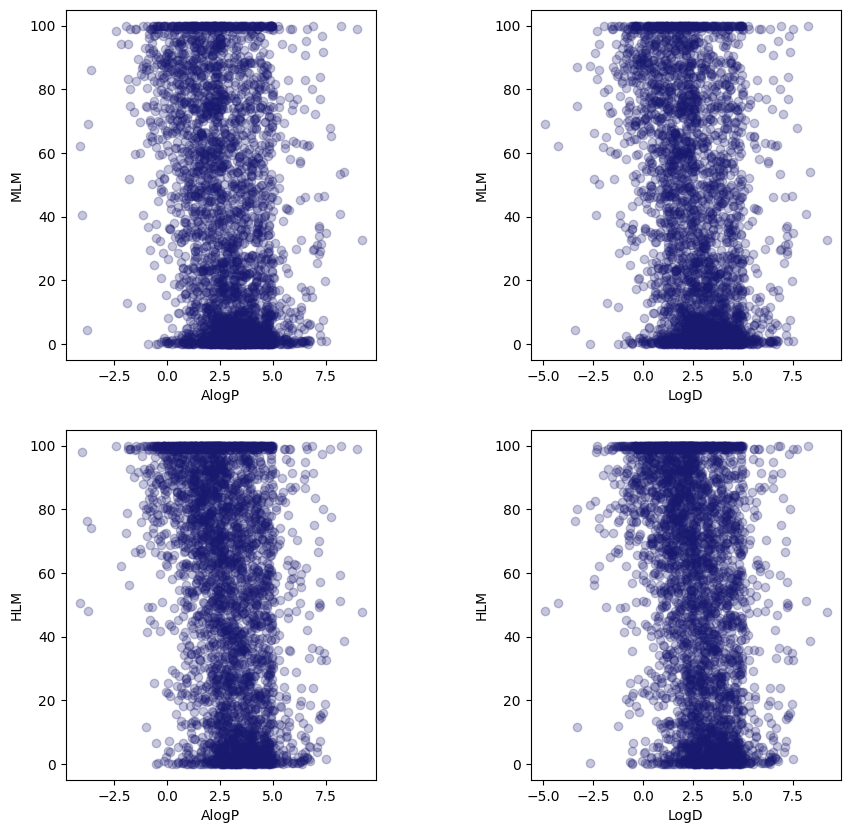

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['MLM', 'HLM']

plt.figure(figsize=(10, 10))

for i in range(len(y_list)):
    for j in range(len(x_list)):
        plt.subplot(2, 2, i * len(x_list) + j + 1)
        plt.scatter(x=x_list[j],
                    y=y_list[i],
                    data=train,
                    c='midnightblue',
                    alpha=0.25)
        plt.xlabel(x_list[j])
        plt.ylabel(y_list[i])
        plt.subplots_adjust(wspace=0.5)

plt.show()

In [12]:
train.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea'],
      dtype='object')

## LogP[D]와 Molecular_Weight의 시각화

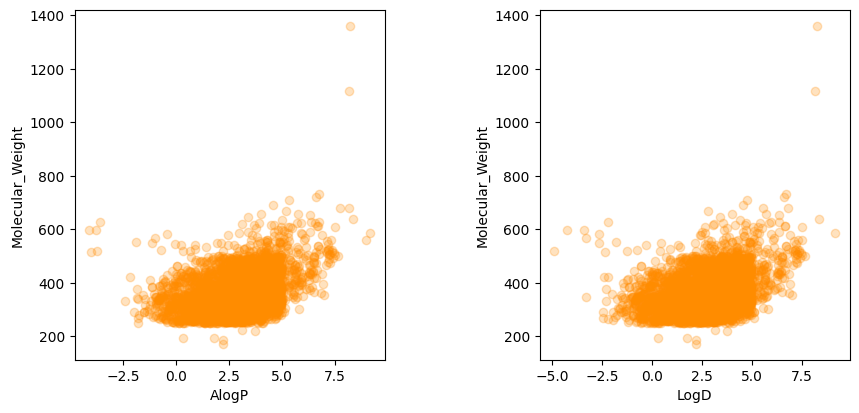

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['Molecular_Weight']

plt.figure(figsize=(10, 10))

for i in range(len(x_list)):
    for j in range(len(y_list)):
        plt.subplot(2, 2, i + 1)
        plt.scatter(x=x_list[i],
                    y=y_list[j],
                    data=train,
                    c='darkorange',
                    alpha=0.25)
        plt.xlabel(x_list[i])
        plt.ylabel(y_list[j])
        plt.subplots_adjust(wspace=0.5)

plt.show()

### 이상치 확인(1,000 초과)

In [13]:
print(len(train[(train['Molecular_Weight'] > 1000.0)]))
display(train[(train['Molecular_Weight'] > 1000.0)])

2


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
1172,TRAIN_1172,COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...,99.900,99.900,8.241,1360.467,15,5,38,8.257,296.43
2711,TRAIN_2711,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,40.761,51.084,8.163,1115.264,10,6,24,8.156,229.23


## LogP[D]와 Num_RotatableBonds 시각화

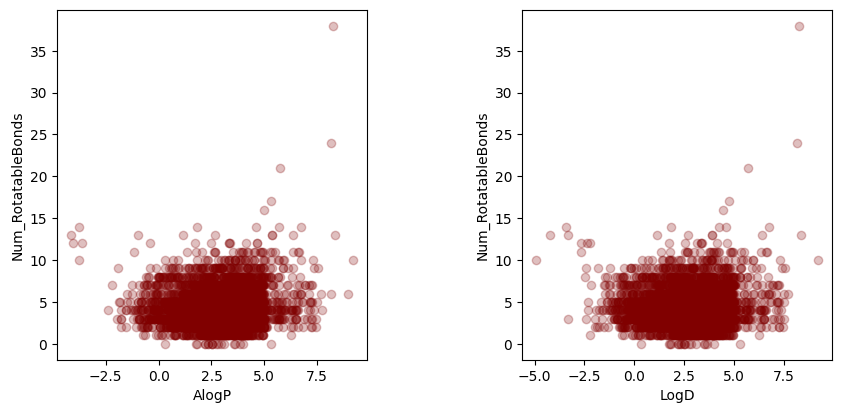

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['Num_RotatableBonds']

plt.figure(figsize=(10, 10))

for i in range(len(x_list)):
    for j in range(len(y_list)):
        plt.subplot(2, 2, i + 1)
        plt.scatter(x=x_list[i],
                    y=y_list[j],
                    data=train,
                    c='maroon',
                    alpha=0.25)
        plt.xlabel(x_list[i])
        plt.ylabel(y_list[j])
        plt.subplots_adjust(wspace=0.5)

plt.show()

### 이상치 확인(20 초과)

In [14]:
print(len(train[(train['Num_RotatableBonds'] > 20)]))
display(train[(train['Num_RotatableBonds'] > 20) ])

3


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
1172,TRAIN_1172,COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...,99.900,99.900,8.241,1360.467,15,5,38,8.257,296.43
2367,TRAIN_2367,[H][C@@](OC(=O)CCC)([C@@]([H])(COC(=O)CCC)OC(=...,0.000,56.260,5.754,656.723,12,1,21,5.703,179.33
2711,TRAIN_2711,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,40.761,51.084,8.163,1115.264,10,6,24,8.156,229.23


## LogP[D]와 Molecular_PolarSurfaceArea 시각화

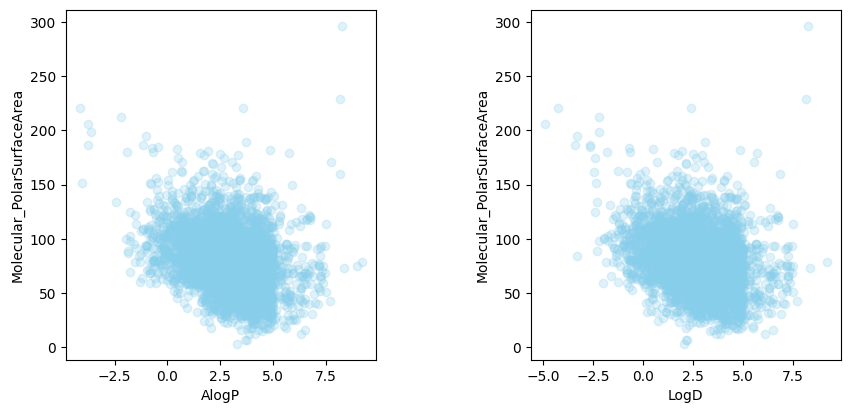

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['Molecular_PolarSurfaceArea']

plt.figure(figsize=(10, 10))

for i in range(len(x_list)):
    for j in range(len(y_list)):
        plt.subplot(2, 2, i + 1)
        plt.scatter(x=x_list[i],
                    y=y_list[j],
                    data=train,
                    c='skyblue',
                    alpha=0.25)
        plt.xlabel(x_list[i])
        plt.ylabel(y_list[j])
        plt.subplots_adjust(wspace=0.5)

plt.show()

### 이상치 확인(250 초과)

In [15]:
print(len(train[(train['Molecular_PolarSurfaceArea'] > 250)]))
display(train[(train['Molecular_PolarSurfaceArea'] > 250) ])

1


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
1172,TRAIN_1172,COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...,99.9,99.9,8.241,1360.467,15,5,38,8.257,296.43


## 이상치 제거(Molecular_Weight, Num_RotatableBonds, Molecular_PolarSurfaceArea)

In [16]:
over_1000 = train[(train['Molecular_Weight'] > 1000.0)]
over_20 = train[(train['Num_RotatableBonds'] > 20) ]
over_250 = train[(train['Molecular_PolarSurfaceArea'] > 250)]

over_1000.index[0], over_20.index[:2], over_250.index[:]

(1172,
 Int64Index([1172, 2367], dtype='int64'),
 Int64Index([1172], dtype='int64'))

In [17]:
over_1000.index, over_20.index, over_250.index

(Int64Index([1172, 2711], dtype='int64'),
 Int64Index([1172, 2367, 2711], dtype='int64'),
 Int64Index([1172], dtype='int64'))

In [18]:
len(train)

3489

In [19]:
train.drop(index=over_20.index, axis=0, inplace=True)
len(train)

3486

- 재확인

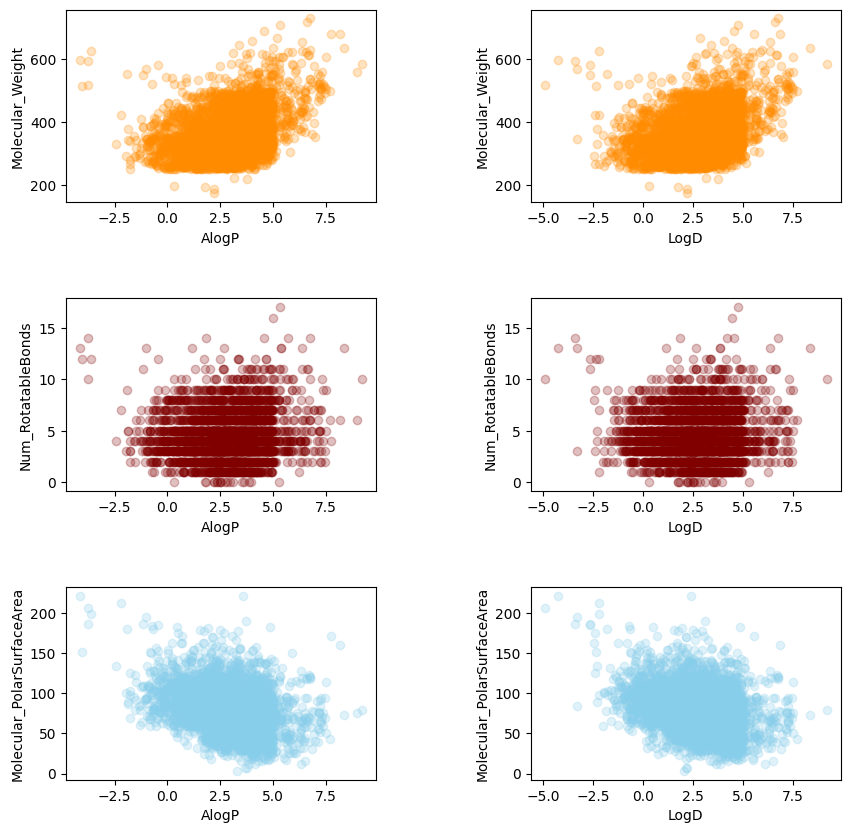

In [ ]:
x_list = ['AlogP', 'LogD']
y_list = ['Molecular_Weight','Num_RotatableBonds','Molecular_PolarSurfaceArea']
colors = ['darkorange','maroon','skyblue']

plt.figure(figsize=(10, 10))

for i in range(len(y_list)):
    for j in range(len(x_list)):
        plt.subplot(len(y_list), len(x_list), i * len(x_list) + j + 1)
        plt.scatter(x=x_list[j],
                    y=y_list[i],
                    data=train,
                    c=colors[i],
                    alpha=0.25)
        plt.xlabel(x_list[j])
        plt.ylabel(y_list[i])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## 중복값 처리
- 2쌍씩 중복되는 케이스 총 27쌍 (54개의 데이터) -> 이상치 제거후에 총 26쌍 됨
- MLM, HLM 데이터만 차이있고 나머지 데이터 값 동일함

- > 둘중 하나 실험 오류로 보고 선택하기? 유사값인 경우 평균내기?

In [20]:
duplicates = train[train.duplicated(subset=['SMILES'], keep=False)]

duplicates.sort_values(by='SMILES')


,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [21]:
duplicates.shape # 이상치 제거로 27 -> 26쌍

(52, 11)

In [22]:
processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()
processed_duplicate

<ipython-input-22-c0f91ccc9bed>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  processed_duplicate = duplicates.groupby('SMILES')['MLM','HLM'].mean().reset_index()


,SMILES,MLM,HLM
0,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615
1,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110
2,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690
3,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850
4,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385
5,CC(C)NC(=O)c1c(Cl)nn(C)c1NC(=O)c1cc(Br)nn1-c1n...,62.1085,68.1015
6,CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(...,43.1700,31.1300
7,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.3395,36.8145
8,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,3.4420,3.6015
9,CCc1nc2cc(Br)c(C(=O)OC)nc2n1CC(=O)c1ccccc1,73.5450,1.1345


In [23]:
tmp = pd.merge(processed_duplicate,duplicates,how='left',on='SMILES')
tmp

,SMILES,MLM_x,HLM_x,id,MLM_y,HLM_y,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615,TRAIN_0451,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
1,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.9225,28.0615,TRAIN_2276,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
2,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110,TRAIN_0543,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
3,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,62.2175,77.9110,TRAIN_2891,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
4,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690,TRAIN_0366,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
5,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690,TRAIN_0837,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
6,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850,TRAIN_1085,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
7,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850,TRAIN_2848,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
8,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385,TRAIN_1666,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85
9,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385,TRAIN_2096,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85


### -> 중복치 제거 (총 26개)

In [24]:
tmp = tmp.iloc[0::2]  # 첫 번째 행부터 시작하여 2씩 증가하여 행 선택
tmp.drop(['MLM_y','HLM_y'],axis =1,inplace=True)

<ipython-input-24-d20f759e9146>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.drop(['MLM_y','HLM_y'],axis =1,inplace=True)


In [25]:
tmp.columns = ['SMILES', 'MLM', 'HLM','id',  'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']

In [26]:
processed_duplicate = tmp[['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea']]

In [27]:
train = train.drop_duplicates(subset=['SMILES'], keep=False) #기존 train에서 중복치들을 우선 모두 제거
train.shape

(3434, 11)

In [28]:
processed_duplicate.shape

(26, 11)

In [29]:
train = pd.concat([train, processed_duplicate], axis=0, ignore_index=True)
train.shape

(3460, 11)

## EDA 완료 : 신약 효과를 다소 많이 볼 수 있는 데이터 추출

In [30]:
train[(train['AlogP'] <= 5) & (train["Molecular_Weight"] <= 400) & (train["Molecular_Weight"] >= 350) &
   (train['Num_RotatableBonds']<=7) & (train['Num_H_Donors'] < 5) & (train['Num_H_Acceptors'] < 10)]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
9,TRAIN_0009,CCN1CCCC1CNC(=O)C1CCCN(c2ncnc3[nH]cnc23)C1,73.4170,76.2910,1.259,357.453,5,2,5,-0.373,90.04
21,TRAIN_0022,O=C(C1CC(=O)N(c2n[nH]c3cc(Br)ccc23)C1)N1CCCC1,99.9000,99.9000,1.907,377.236,3,1,2,1.907,69.30
27,TRAIN_0028,CC(C)CCN(C)C1CCN(S(=O)(=O)c2ccc(C(C)(C)C)cc2)CC1,3.8550,54.2180,4.038,380.588,3,0,7,2.478,49.00
31,TRAIN_0032,c1ccc2c(c1)OCC(c1csc(C3COc4ccccc4O3)n1)O2,55.9410,78.0130,3.703,353.392,5,0,2,3.703,78.05
34,TRAIN_0035,O=C(Nc1ccccc1Cl)NC1(C(=O)N2CCC(O)CC2)CCCCC1,81.5700,99.0000,2.237,379.881,3,3,3,2.237,81.67
...,...,...,...,...,...,...,...,...,...,...,...
3436,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,68.6310,64.6690,2.293,367.428,5,2,3,2.307,139.85
3437,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,32.1435,85.6850,1.684,381.450,7,1,4,1.684,126.52
3438,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,3.6870,43.3385,2.843,360.490,3,0,4,2.843,49.85
3440,TRAIN_0328,CC1CC(=O)N(c2ccc(-c3cccc(C#N)c3)cc2)N=C1c1ccc(...,43.1700,31.1300,4.449,381.427,4,1,3,4.446,76.69


- 결측치 확인

In [32]:
train.isnull().sum().sum() , test.isnull().sum().sum()

(0, 0)

In [ ]:
# train[(train["AlogP"] >= 7) | (train["AlogP"] <= -1)]

In [33]:
train.describe()

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
count,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000,3460.000000
mean,37.312814,53.040546,2.836132,363.128672,4.006647,1.098555,4.542486,2.675094,79.599977
std,35.605097,36.006796,1.600467,76.394755,1.490536,0.972800,2.247658,1.659351,28.498598
min,0.000000,0.000000,-4.137000,172.180000,0.000000,0.000000,0.000000,-4.920000,3.240000
25%,2.448000,15.956500,1.828750,304.383250,3.000000,0.000000,3.000000,1.611750,60.002500
50%,26.193000,58.023000,2.883500,349.641500,4.000000,1.000000,4.000000,2.703000,77.520000
75%,70.692500,87.669250,3.958000,409.502000,5.000000,2.000000,6.000000,3.858000,96.500000
max,99.990000,99.990000,9.190000,730.737000,13.000000,10.000000,17.000000,9.190000,220.860000


## 컬럼별 최빈값 확인

In [34]:
import statistics

for i in train.describe().columns:
    print(i, ":", statistics.mode(train[i]))

MLM : 99.99
HLM : 99.99
AlogP : 3.886
Molecular_Weight : 313.351
Num_H_Acceptors : 4
Num_H_Donors : 1
Num_RotatableBonds : 4
LogD : 2.721
Molecular_PolarSurfaceArea : 58.64


- EDA 데이터 저장

In [35]:
# train.to_csv(f'{DATA_PATH}train_EDA.csv', index=False, encoding = "utf-8-sig") # LogD, 이상치 제거
train.to_csv(f'{DATA_PATH}train_EDA_ver4.csv', index=False, encoding = "utf-8-sig") # LogD, 이상치 제거, 중복값 제거

# EDA 데이터 불러오기

In [36]:
# train = pd.read_csv(f'{DATA_PATH}train_EDA.csv')
train = pd.read_csv(f'{DATA_PATH}train_EDA_ver4.csv')
train

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.0100,50.6800,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.2700,50.5900,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.5860,80.8920,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.7100,2.0000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.2700,99.9900,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3455,TRAIN_1833,Cc1ccc(-c2cc(-c3nc4c5ccccc5ncn4n3)[nH]n2)c(C)c1,28.4630,24.1955,4.609,340.381,4,1,2,4.736,71.75
3456,TRAIN_0898,Cc1ccc(-c2ccc(C(CN3CCCC3)N(C)C(=O)CN3C(=O)COc4...,56.0435,66.1260,4.282,553.480,5,0,7,4.009,65.98
3457,TRAIN_2575,Cc1ccccc1-c1nc2ccccc2cc1C(C)n1c(=O)[nH]c2c(S(C...,56.3130,63.7320,4.304,459.520,6,1,4,4.304,113.53
3458,TRAIN_0216,N#Cc1nccnc1OC1CCN(C(=O)C2CC(=O)N(C3CCOCC3)C2)C1,70.2150,93.8400,-1.133,385.417,7,0,4,-1.133,108.65


In [37]:
train.mode()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,Brc1c[nH]nc1-c1nc2c3ccccc3ncn2n1,99.99,99.99,2.535,313.351,4.0,1.0,4.0,2.721,58.64
1,TRAIN_0001,Brc1cc(-c2noc([C@H]3CCCO3)n2)c2ncnn2c1,NaN,NaN,3.383,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAIN_0002,Brc1ccc(-c2c[nH]c(CNc3nncn3-c3ccccc3)n2)cc1,NaN,NaN,3.691,NaN,NaN,NaN,NaN,NaN,NaN
3,TRAIN_0003,Brc1ccc(-c2n[nH]c(-c3ccccc3)c2-c2ncc[nH]2)cc1,NaN,NaN,3.886,NaN,NaN,NaN,NaN,NaN,NaN
4,TRAIN_0004,Brc1ccc(C2CC(c3ccc(Br)cc3)n3ncnc3N2)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3455,TRAIN_3493,c1cnc2c(c1)OC(Cn1nnc3ncc(-c4ccc(OCC5CCNCC5)cc4...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3456,TRAIN_3494,c1csc(COc2ccc(CNn3cnnc3)cc2)c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3457,TRAIN_3495,c1nc(N2CCCC2)sc1CN1CC[C@H]2OCc3cnnn3[C@H]2C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3458,TRAIN_3496,c1nc(N2CCN(C3CCCCC3)CC2)c2nc[nH]c2n1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


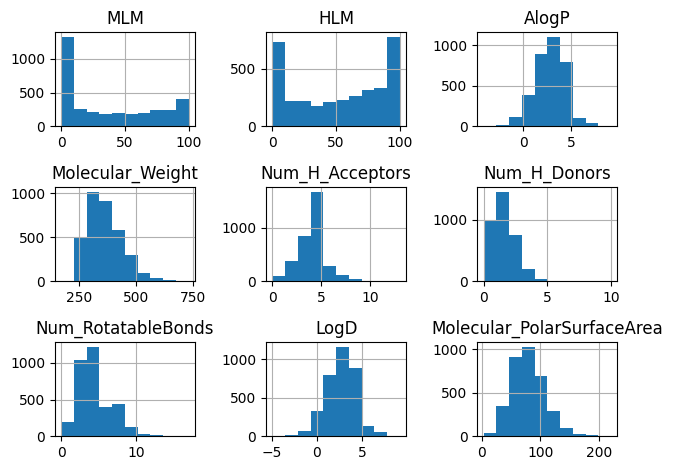

In [38]:
train.hist()
plt.tight_layout() # 그래프 간격 설정
plt.show()

# 샘플 테스트

In [39]:
train_prop = train.iloc[:, 4:]
test_prop = test.iloc[:, 2:]

target_1 = train['MLM']
target_2 = train['HLM']

In [40]:
train_prop

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,3.259,400.495,5,2,8,3.259,117.37
1,2.169,301.407,2,1,2,2.172,73.47
2,1.593,297.358,5,0,3,1.585,62.45
3,4.771,494.652,6,0,5,3.475,92.60
4,2.335,268.310,3,0,1,2.337,42.43
...,...,...,...,...,...,...,...
3455,4.609,340.381,4,1,2,4.736,71.75
3456,4.282,553.480,5,0,7,4.009,65.98
3457,4.304,459.520,6,1,4,4.304,113.53
3458,-1.133,385.417,7,0,4,-1.133,108.65


In [41]:
test_prop

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,2.641,361.505,4,2,7,2.635,92.76
1,0.585,370.399,5,0,3,0.585,68.31
2,4.276,347.414,4,4,5,4.290,92.86
3,1.795,345.358,5,0,2,1.795,81.21
4,1.219,353.418,4,0,2,0.169,61.15
...,...,...,...,...,...,...,...
478,4.207,306.443,2,1,7,4.207,55.13
479,-0.608,335.398,5,0,1,-1.736,70.16
480,1.792,349.383,3,1,3,1.792,69.72
481,0.790,341.132,3,2,2,0.423,69.64


#### randomforest

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = RandomForestRegressor(random_state=SEED)
    model.fit(x_train, y_train_1)
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    #HLM
    model = RandomForestRegressor(random_state=SEED)
    model.fit(x_train, y_train_2)
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)

    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[32.488064723008634, 33.3190559788743, 32.06787342880368, 33.150237337273225, 32.88111932049365]


32.7812701576907

- EDA 전 : 33.05806187997771
- ver1 : 32.867040035781386
- ver4 : 32.7812701576907

In [43]:
model.fit(train_prop, target_1)
rf_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
rf_pred_2 = model.predict(test_prop)

#### XGBRegressor

In [44]:
scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = XGBRegressor(random_state=SEED)
    model.fit(x_train, y_train_1, eval_set=[(x_valid, y_valid_1)], eval_metric='rmse')
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    # HLM
    model = XGBRegressor(random_state=SEED)
    model.fit(x_train, y_train_2, eval_set=[(x_valid, y_valid_2)], eval_metric='rmse')
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)

    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[0]	validation_0-rmse:42.43289
[1]	validation_0-rmse:37.52533
[2]	validation_0-rmse:34.76004
[3]	validation_0-rmse:33.37716
[4]	validation_0-rmse:32.78274
[5]	validation_0-rmse:32.43257
[6]	validation_0-rmse:32.45856
[7]	validation_0-rmse:32.31614
[8]	validation_0-rmse:32.27768
[9]	validation_0-rmse:32.29936
[10]	validation_0-rmse:32.28074
[11]	validation_0-rmse:32.30722
[12]	validation_0-rmse:32.32213
[13]	validation_0-rmse:32.32815
[14]	validation_0-rmse:32.39434
[15]	validation_0-rmse:32.41073
[16]	validation_0-rmse:32.39670
[17]	validation_0-rmse:32.51231


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:32.69772
[19]	validation_0-rmse:32.86857
[20]	validation_0-rmse:32.92719
[21]	validation_0-rmse:32.91550
[22]	validation_0-rmse:32.87358
[23]	validation_0-rmse:33.02016
[24]	validation_0-rmse:32.97186
[25]	validation_0-rmse:33.00913
[26]	validation_0-rmse:33.09562
[27]	validation_0-rmse:33.17713
[28]	validation_0-rmse:33.10766
[29]	validation_0-rmse:33.10654
[30]	validation_0-rmse:33.14588
[31]	validation_0-rmse:33.22050
[32]	validation_0-rmse:33.22253
[33]	validation_0-rmse:33.26900
[34]	validation_0-rmse:33.38165
[35]	validation_0-rmse:33.42152
[36]	validation_0-rmse:33.43563
[37]	validation_0-rmse:33.50279
[38]	validation_0-rmse:33.52468
[39]	validation_0-rmse:33.49894
[40]	validation_0-rmse:33.57201
[41]	validation_0-rmse:33.64438
[42]	validation_0-rmse:33.66276
[43]	validation_0-rmse:33.67654
[44]	validation_0-rmse:33.73162
[45]	validation_0-rmse:33.74284
[46]	validation_0-rmse:33.71040
[47]	validation_0-rmse:33.74451
[48]	validation_0-rmse:33.73560
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:33.19492
[22]	validation_0-rmse:33.26167
[23]	validation_0-rmse:33.42708
[24]	validation_0-rmse:33.47557
[25]	validation_0-rmse:33.52943
[26]	validation_0-rmse:33.65342
[27]	validation_0-rmse:33.74425
[28]	validation_0-rmse:33.75043
[29]	validation_0-rmse:33.85663
[30]	validation_0-rmse:33.83006
[31]	validation_0-rmse:33.85044
[32]	validation_0-rmse:33.84625
[33]	validation_0-rmse:33.85841
[34]	validation_0-rmse:33.85259
[35]	validation_0-rmse:33.87927
[36]	validation_0-rmse:33.88419
[37]	validation_0-rmse:33.93364
[38]	validation_0-rmse:33.92912
[39]	validation_0-rmse:33.93989
[40]	validation_0-rmse:34.04855
[41]	validation_0-rmse:34.06402
[42]	validation_0-rmse:34.18240
[43]	validation_0-rmse:34.17184
[44]	validation_0-rmse:34.19111
[45]	validation_0-rmse:34.25302
[46]	validation_0-rmse:34.23517
[47]	validation_0-rmse:34.27912
[48]	validation_0-rmse:34.34291
[49]	validation_0-rmse:34.41831
[50]	validation_0-rmse:34.42382
[51]	validation_0-rmse:34.41990
[52]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:33.99443
[22]	validation_0-rmse:33.92714
[23]	validation_0-rmse:33.94851
[24]	validation_0-rmse:33.95110
[25]	validation_0-rmse:34.01266
[26]	validation_0-rmse:34.07667
[27]	validation_0-rmse:34.08417
[28]	validation_0-rmse:34.03523
[29]	validation_0-rmse:34.04813
[30]	validation_0-rmse:34.04869
[31]	validation_0-rmse:34.09417
[32]	validation_0-rmse:34.09084
[33]	validation_0-rmse:34.09525
[34]	validation_0-rmse:34.07620
[35]	validation_0-rmse:34.08823
[36]	validation_0-rmse:34.10152
[37]	validation_0-rmse:34.12840
[38]	validation_0-rmse:34.15646
[39]	validation_0-rmse:34.20405
[40]	validation_0-rmse:34.21532
[41]	validation_0-rmse:34.22342
[42]	validation_0-rmse:34.15813
[43]	validation_0-rmse:34.16146
[44]	validation_0-rmse:34.24033
[45]	validation_0-rmse:34.24006
[46]	validation_0-rmse:34.17928
[47]	validation_0-rmse:34.18639
[48]	validation_0-rmse:34.24147
[49]	validation_0-rmse:34.26264
[50]	validation_0-rmse:34.27729
[51]	validation_0-rmse:34.27475
[52]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:33.14557
[22]	validation_0-rmse:33.12821
[23]	validation_0-rmse:33.17775
[24]	validation_0-rmse:33.22008
[25]	validation_0-rmse:33.25998
[26]	validation_0-rmse:33.27051
[27]	validation_0-rmse:33.31029
[28]	validation_0-rmse:33.35354
[29]	validation_0-rmse:33.41426
[30]	validation_0-rmse:33.52127
[31]	validation_0-rmse:33.64883
[32]	validation_0-rmse:33.64642
[33]	validation_0-rmse:33.65453
[34]	validation_0-rmse:33.67486
[35]	validation_0-rmse:33.71422
[36]	validation_0-rmse:33.77555
[37]	validation_0-rmse:33.85788
[38]	validation_0-rmse:33.86047
[39]	validation_0-rmse:33.90146
[40]	validation_0-rmse:33.94759
[41]	validation_0-rmse:33.95702
[42]	validation_0-rmse:34.03182
[43]	validation_0-rmse:34.12135
[44]	validation_0-rmse:34.23143
[45]	validation_0-rmse:34.24853
[46]	validation_0-rmse:34.23209
[47]	validation_0-rmse:34.22818
[48]	validation_0-rmse:34.29393
[49]	validation_0-rmse:34.33721
[50]	validation_0-rmse:34.35570
[51]	validation_0-rmse:34.40697
[52]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:31.81492
[22]	validation_0-rmse:31.83429
[23]	validation_0-rmse:31.94204
[24]	validation_0-rmse:31.97468
[25]	validation_0-rmse:32.01639
[26]	validation_0-rmse:31.98383
[27]	validation_0-rmse:32.03071
[28]	validation_0-rmse:32.12102
[29]	validation_0-rmse:32.16127
[30]	validation_0-rmse:32.29424
[31]	validation_0-rmse:32.37066
[32]	validation_0-rmse:32.41307
[33]	validation_0-rmse:32.41901
[34]	validation_0-rmse:32.55202
[35]	validation_0-rmse:32.47160
[36]	validation_0-rmse:32.44605
[37]	validation_0-rmse:32.46628
[38]	validation_0-rmse:32.44627
[39]	validation_0-rmse:32.50115
[40]	validation_0-rmse:32.48657
[41]	validation_0-rmse:32.50444
[42]	validation_0-rmse:32.53769
[43]	validation_0-rmse:32.56547
[44]	validation_0-rmse:32.56478
[45]	validation_0-rmse:32.58755
[46]	validation_0-rmse:32.59373
[47]	validation_0-rmse:32.59678
[48]	validation_0-rmse:32.62440
[49]	validation_0-rmse:32.64214
[50]	validation_0-rmse:32.69434
[51]	validation_0-rmse:32.73357
[52]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:32.35239
[19]	validation_0-rmse:32.55124
[20]	validation_0-rmse:32.55842
[21]	validation_0-rmse:32.57288
[22]	validation_0-rmse:32.62544
[23]	validation_0-rmse:32.63962
[24]	validation_0-rmse:32.71402
[25]	validation_0-rmse:32.73284
[26]	validation_0-rmse:32.86425
[27]	validation_0-rmse:32.85780
[28]	validation_0-rmse:32.91385
[29]	validation_0-rmse:32.87729
[30]	validation_0-rmse:32.88413
[31]	validation_0-rmse:32.87875
[32]	validation_0-rmse:32.95897
[33]	validation_0-rmse:32.94001
[34]	validation_0-rmse:32.93516
[35]	validation_0-rmse:32.96868
[36]	validation_0-rmse:32.98649
[37]	validation_0-rmse:32.93996
[38]	validation_0-rmse:32.89363
[39]	validation_0-rmse:32.94735
[40]	validation_0-rmse:33.02157
[41]	validation_0-rmse:33.02363
[42]	validation_0-rmse:33.00355
[43]	validation_0-rmse:32.99715
[44]	validation_0-rmse:33.01859
[45]	validation_0-rmse:33.08464
[46]	validation_0-rmse:33.08742
[47]	validation_0-rmse:33.12144
[48]	validation_0-rmse:33.11921
[49]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:32.94880
[14]	validation_0-rmse:32.94692
[15]	validation_0-rmse:32.98080
[16]	validation_0-rmse:33.01094
[17]	validation_0-rmse:33.05627
[18]	validation_0-rmse:33.11672
[19]	validation_0-rmse:33.13400
[20]	validation_0-rmse:33.17616
[21]	validation_0-rmse:33.19983
[22]	validation_0-rmse:33.26386
[23]	validation_0-rmse:33.18640
[24]	validation_0-rmse:33.19417
[25]	validation_0-rmse:33.22544
[26]	validation_0-rmse:33.26290
[27]	validation_0-rmse:33.30973
[28]	validation_0-rmse:33.33365
[29]	validation_0-rmse:33.34654
[30]	validation_0-rmse:33.36419
[31]	validation_0-rmse:33.40935
[32]	validation_0-rmse:33.39868
[33]	validation_0-rmse:33.47599
[34]	validation_0-rmse:33.47957
[35]	validation_0-rmse:33.54096
[36]	validation_0-rmse:33.54888
[37]	validation_0-rmse:33.57816
[38]	validation_0-rmse:33.59455
[39]	validation_0-rmse:33.64949
[40]	validation_0-rmse:33.73154
[41]	validation_0-rmse:33.82329
[42]	validation_0-rmse:33.87623
[43]	validation_0-rmse:33.93320
[44]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:33.43219
[12]	validation_0-rmse:33.49778
[13]	validation_0-rmse:33.51151
[14]	validation_0-rmse:33.51458
[15]	validation_0-rmse:33.48765
[16]	validation_0-rmse:33.51767
[17]	validation_0-rmse:33.50219
[18]	validation_0-rmse:33.54642
[19]	validation_0-rmse:33.52439
[20]	validation_0-rmse:33.60588
[21]	validation_0-rmse:33.71833
[22]	validation_0-rmse:33.71080
[23]	validation_0-rmse:33.73587
[24]	validation_0-rmse:33.76729
[25]	validation_0-rmse:33.75501
[26]	validation_0-rmse:33.77319
[27]	validation_0-rmse:33.85006
[28]	validation_0-rmse:33.96682
[29]	validation_0-rmse:34.08029
[30]	validation_0-rmse:34.07246
[31]	validation_0-rmse:34.10468
[32]	validation_0-rmse:34.09441
[33]	validation_0-rmse:34.10492
[34]	validation_0-rmse:34.09994
[35]	validation_0-rmse:34.12666
[36]	validation_0-rmse:34.13728
[37]	validation_0-rmse:34.24678
[38]	validation_0-rmse:34.30329
[39]	validation_0-rmse:34.35455
[40]	validation_0-rmse:34.34618
[41]	validation_0-rmse:34.31414
[42]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:31.68943
[12]	validation_0-rmse:31.81823
[13]	validation_0-rmse:31.82806
[14]	validation_0-rmse:31.84400
[15]	validation_0-rmse:31.86050
[16]	validation_0-rmse:31.84739
[17]	validation_0-rmse:31.82281
[18]	validation_0-rmse:31.73278
[19]	validation_0-rmse:31.73347
[20]	validation_0-rmse:31.87082
[21]	validation_0-rmse:31.88767
[22]	validation_0-rmse:31.99593
[23]	validation_0-rmse:32.04027
[24]	validation_0-rmse:32.07565
[25]	validation_0-rmse:32.13217
[26]	validation_0-rmse:32.14264
[27]	validation_0-rmse:32.19547
[28]	validation_0-rmse:32.28069
[29]	validation_0-rmse:32.29501
[30]	validation_0-rmse:32.22649
[31]	validation_0-rmse:32.26334
[32]	validation_0-rmse:32.33230
[33]	validation_0-rmse:32.35447
[34]	validation_0-rmse:32.41368
[35]	validation_0-rmse:32.40835
[36]	validation_0-rmse:32.42946
[37]	validation_0-rmse:32.44802
[38]	validation_0-rmse:32.44695
[39]	validation_0-rmse:32.45850
[40]	validation_0-rmse:32.51930
[41]	validation_0-rmse:32.51539
[42]	val

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-rmse:33.89086
[22]	validation_0-rmse:33.94270
[23]	validation_0-rmse:33.96487
[24]	validation_0-rmse:33.94437
[25]	validation_0-rmse:33.93281
[26]	validation_0-rmse:33.91323
[27]	validation_0-rmse:33.89982
[28]	validation_0-rmse:33.89257
[29]	validation_0-rmse:33.95471
[30]	validation_0-rmse:34.04896
[31]	validation_0-rmse:34.06884
[32]	validation_0-rmse:34.04029
[33]	validation_0-rmse:34.08052
[34]	validation_0-rmse:34.10099
[35]	validation_0-rmse:34.10694
[36]	validation_0-rmse:34.19740
[37]	validation_0-rmse:34.24278
[38]	validation_0-rmse:34.28936
[39]	validation_0-rmse:34.25854
[40]	validation_0-rmse:34.25981
[41]	validation_0-rmse:34.33060
[42]	validation_0-rmse:34.40810
[43]	validation_0-rmse:34.41947
[44]	validation_0-rmse:34.45150
[45]	validation_0-rmse:34.53399
[46]	validation_0-rmse:34.50755
[47]	validation_0-rmse:34.52943
[48]	validation_0-rmse:34.50485
[49]	validation_0-rmse:34.53208
[50]	validation_0-rmse:34.53987
[51]	validation_0-rmse:34.57653
[52]	val

34.60166118253876

- EDA 전 : 34.594325496231924
- ver1 : 34.47645590589853
- ver4 : 34.60166118253876

In [45]:
model.fit(train_prop, target_1)
xgb_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
xgb_pred_2 = model.predict(test_prop)

#### LGBMRegressor

In [46]:
scores = []
for tri, val in cv.split(train_prop, target_1):
    # 학습데이터
    x_train = train_prop.iloc[tri]
    y_train_1 = target_1.iloc[tri]
    y_train_2 = target_2.iloc[tri]

    # 검증데이터
    x_valid = train_prop.iloc[val]
    y_valid_1 = target_1.iloc[val]
    y_valid_2 = target_2.iloc[val]

    # MLM
    model = LGBMRegressor(random_state=SEED, objective='regression')
    model.fit(x_train, y_train_1, eval_set=[(x_valid, y_valid_1)], eval_metric="rmse")
    pred = model.predict(x_valid)
    score_1 = rmse(y_valid_1, pred)

    # HLM
    model = LGBMRegressor(random_state=SEED, objective='regression')
    model.fit(x_train, y_train_2, eval_set=[(x_valid, y_valid_2)], eval_metric="rmse")
    pred = model.predict(x_valid)
    score_2 = rmse(y_valid_2, pred)


    score = 0.5*score_1 + 0.5*score_2
    scores.append(score)

print(scores)
np.mean(scores)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 7
[LightGBM] [Info] Start training from score 37.181329
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 7
[LightGBM] [Info] Start training from score 52.698230
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

33.06255374801817

- EDA 전 : 33.07062315344373
- ver1 : 32.81682981788737
- ver4 : 33.06255374801817

In [47]:
model.fit(train_prop, target_1)
lgbm_pred_1 = model.predict(test_prop)

model.fit(train_prop, target_2)
lgbm_pred_2 = model.predict(test_prop)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 7
[LightGBM] [Info] Start training from score 37.312814
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 7
[LightGBM] [Info] Start training from score 53.040546


In [48]:
# mlm_pred = (rf_pred_1 + xgb_pred_1 + lgbm_pred_1) / 3
# hlm_pred = (rf_pred_2 + xgb_pred_2 + lgbm_pred_2) / 3

# 가중 평균
mlm_pred = (rf_pred_1*0.35) + (xgb_pred_1*0.3) + (lgbm_pred_1*0.35)
hlm_pred = (rf_pred_2*0.35) + (xgb_pred_2*0.3) + (lgbm_pred_2*0.35)

In [49]:
submission['MLM'] = mlm_pred
submission['HLM'] = hlm_pred

In [50]:
submission

,id,MLM,HLM
0,TEST_000,31.257775,53.247250
1,TEST_001,64.807061,79.313633
2,TEST_002,27.913104,44.053804
3,TEST_003,45.129941,73.358170
4,TEST_004,50.473503,77.254610
...,...,...,...
478,TEST_478,8.845602,30.614105
479,TEST_479,76.623855,87.963166
480,TEST_480,36.576963,73.286072
481,TEST_481,67.865019,79.983686


In [51]:
submission.to_csv(f"{DATA_PATH}sub_EDA_ver4.csv", index=False)